In [1]:
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yatin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
pd.set_option('display.max_colwidth', 900, "display.max_columns", 30, "display.max_rows", 100)
tweets_whole = pd.read_csv('vaccination_all_tweets.csv')
tweets_whole.head(5)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radio Network. Weeknights 7 Pacific-10 Eastern - Email comments/ideas to charles@charlesadlertonight.ca",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [4]:
tweets_data = tweets_whole.drop(['user_name', 'user_location', 
                                'user_description', 'user_created', 
                                'user_followers', 'user_friends', 
                                'user_favourites', 'user_verified', 
                                'source', 'retweets', 'favorites', 'is_retweet'], axis=1)

tweets_data['date'] = pd.to_datetime(tweets_data['date']).dt.date
tweets_data['hashtags'] = tweets_data['hashtags'].fillna('Notags')
tweets_data['hashtags'] = [re.sub("[(\[\')|(\]\')|\s]", '', tags) for tags in tweets_data['hashtags']]
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33717 entries, 0 to 33716
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        33717 non-null  int64 
 1   date      33717 non-null  object
 2   text      33717 non-null  object
 3   hashtags  33717 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


In [5]:
tweets_data.head(2)

,id,date,text,hashtags
0,1340539111971516416,2020-12-20,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,PfizerBioNTech
1,1338158543359250433,2020-12-13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",Notags


In [6]:
# prepare stopwords
stopwords = set(stopwords.words('english'))

# this 'deEmojify': via https://www.kaggle.com/sharibkhan/my-first-semantic-analysis-problem-in-nlp
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

def nlp(text):
    corpus = []
    text = deEmojify(text)
    text = re.sub('http\S+', '', text) # remove url
    text = re.sub('#\w+', '', text) # remove hashtags
    text = re.sub('@[^\s]+', '', text) # remove @twitter_id
    text = text.split()
    corpus = [txt for txt in text if not txt in stopwords]
    return ' '.join(corpus)

tweets_data['text_nlp'] = tweets_data['text'].apply(lambda x: nlp(x))
tweets_data['text_nlp'].head()


0                                  Same folks said daikon paste could treat cytokine storm
1      While world wrong side history year, hopefully, biggest vaccination effort we've ev
2                                                   Russian vaccine created last 2-4 years
3    Facts immutable, Senator, even ethically sturdy enough acknowledge them. (1) You born
4                                                                     Explain need vaccine
Name: text_nlp, dtype: object

In [7]:
# sample = tweets_data['text_nlp'][22]
# print(sample)

# testimonial = TextBlob(sample)
# pola = testimonial.sentiment.polarity
# subj = testimonial.sentiment.subjectivity
# print('pola', pola, 'subj', subj)

Trump announces rollout 'in less 24 hours' The first Americans vaccinated
pola 0.04166666666666667 subj 0.19999999999999998


In [8]:
# sample = 'Thank you, but I finally use other items another gave me'
# print(sample)

# testimonial = TextBlob(sample)
# pola = testimonial.sentiment.polarity
# subj = testimonial.sentiment.subjectivity
# print('pola', pola, 'subj', subj)

Thank you, but I finally use other items another gave me
pola -0.0625 subj 0.6875


In [49]:
def polarity(text):
    testimonial = TextBlob(text)
    polarity = testimonial.sentiment.polarity
    return polarity


def subjectivity(text):
    testimonial = TextBlob(text)
    subjectivity = testimonial.subjectivity
    return subjectivity


def senti(text, polarity_threshold=0):
    testimonial = TextBlob(text)
    senti = testimonial.sentiment.polarity
    
    if senti >= polarity_threshold:
        return 'Positive'
#     elif np.abs(senti) < polarity_threshold:
#         return 'Neutral'
    else:
        return 'Negative'
    

tweets_data['polarity'] = tweets_data['text_nlp'].apply(lambda x: polarity(x))
tweets_data['subjectivity'] = tweets_data['text_nlp'].apply(lambda x: subjectivity(x))
tweets_data['sentiment'] = tweets_data['text_nlp'].apply(lambda x: senti(x))
tweets_data.head(10)

,id,date,text,hashtags,text_nlp,polarity,subjectivity,sentiment
0,1340539111971516416,2020-12-20,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,PfizerBioNTech,Same folks said daikon paste could treat cytokine storm,0.000,0.125000,Positive
1,1338158543359250433,2020-12-13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",Notags,"While world wrong side history year, hopefully, biggest vaccination effort we've ev",-0.500,0.900000,Negative
2,1337858199140118533,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"coronavirus,SputnikV,AstraZeneca,PfizerBioNTech,Moderna,Covid_19",Russian vaccine created last 2-4 years,0.000,0.033333,Positive
3,1337855739918835717,2020-12-12,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",Notags,"Facts immutable, Senator, even ethically sturdy enough acknowledge them. (1) You born",0.100,0.550000,Positive
4,1337854064604966912,2020-12-12,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,"whereareallthesickpeople,PfizerBioNTech",Explain need vaccine,0.000,0.000000,Positive
5,1337852648389832708,2020-12-12,Does anyone have any useful advice/guidance for whether the COVID vaccine is safe whilst breastfeeding?… https://t.co/EifsyQoeKN,Notags,Does anyone useful advice/guidance whether COVID vaccine safe whilst breastfeeding?,0.400,0.250000,Positive
6,1337851215875608579,2020-12-12,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",vaccination,"bit sad claim fame success patriotic competition USA, Canada, UK",-0.100,0.500000,Negative
7,1337850832256176136,2020-12-12,There have not been many bright days in 2020 but here are some of the best \n1. #BidenHarris winning #Election2020… https://t.co/77u4f8XXfx,"BidenHarris,Election2020",There many bright days 2020 best 1. winning,0.675,0.587500,Positive
8,1337850023531347969,2020-12-12,Covid vaccine; You getting it?\n\n #CovidVaccine #covid19 #PfizerBioNTech #Moderna,"CovidVaccine,covid19,PfizerBioNTech,Moderna",Covid vaccine; You getting it?,0.000,0.000000,Positive
9,1337842295857623042,2020-12-12,"#CovidVaccine \n\nStates will start getting #COVID19Vaccine Monday, #US says \n#pakustv #NYC #Healthcare #GlobalGoals… https://t.co/MksOvBvs5w","CovidVaccine,COVID19Vaccine,US,pakustv,NYC,Healthcare,GlobalGoals","States start getting Monday, says",0.000,0.000000,Positive


In [10]:
# fig, ax = plt.subplots(3, 1, figsize=(15, 15))
# sentiments = tweets_data['sentiment'].unique()
# for i, senti in enumerate(sentiments):
#     senti_df = tweets_data.query('sentiment==@senti')
#     cloud = ' '.join([tweet for tweet in senti_df['text_nlp']])
#     wc = WordCloud(max_words=2000, width=1600, \
#                    height=800, stopwords=stopwords).generate(cloud)

#     ax[i].set_title(senti, fontsize=25)
#     ax[i].axis('off')
#     ax[i].imshow(wc , interpolation = 'bilinear')
    
# plt.tight_layout()
# plt.show()

In [11]:

# fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharey=True, sharex=True)

# sentiments = tweets_data['sentiment'].unique()
# colors = ['green', 'blue', 'red']
# plt.suptitle('words in texts', fontsize=30)
# for i, senti in enumerate(sentiments):
#     senti_df = tweets_data.query('sentiment==@senti')
#     # number of words in text
#     # ex. 'Explain need vaccine' -> 3
#     words_len = senti_df['text_nlp'].str.split().map(lambda x: len(x))
#     ax[i].set_title(senti, fontsize=25)
#     ax[i].hist(words_len, color=colors[i], bins=20)
    
# plt.tight_layout()
# plt.show()

In [50]:
def split(string):
    return string.split(" ")

In [64]:
X=tweets_data['text_nlp']
y=tweets_data['sentiment']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [66]:
vectoriser = TfidfVectorizer()
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  18576


In [67]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [18]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# corpus = [
#      'This is the first document.',
#      'This document is the second document.',
#      'And this is the third one.',
#      'Is this the first document?']
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(corpus)
# print(X)


In [19]:
X_train.shape

(25287, 18553)

In [20]:
y_train

32836    0.250000
22146   -0.100000
22190   -0.316667
17772    0.000000
21085    0.000000
           ...   
4376     0.000000
9695     0.000000
17263    0.250000
17082    0.000000
937      0.000000
Name: polarity, Length: 25287, dtype: float64

In [79]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_pred, y_test)
#     print(cf_matrix)
    categories = ['Negative','Positive']
    group_names = ['True Neg ','False Pos ', 'False Neg ','True Pos ']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1} n {v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [80]:
# y_train=y_train.astype('int')
# y_test=y_test.astype('int')

              precision    recall  f1-score   support

    Negative       0.74      0.19      0.31       952
    Positive       0.91      0.99      0.95      7478

    accuracy                           0.90      8430
   macro avg       0.83      0.59      0.63      8430
weighted avg       0.89      0.90      0.87      8430

Test Accuracy: 0.9014


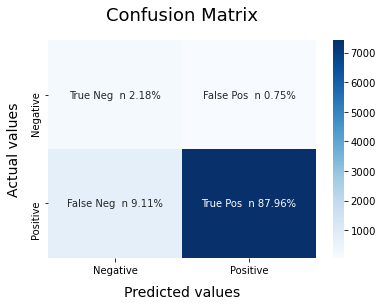

In [81]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)
print("Test Accuracy: %0.4f" % BNBmodel.score(X_test, y_test))

              precision    recall  f1-score   support

    Negative       0.88      0.70      0.78       952
    Positive       0.96      0.99      0.98      7478

    accuracy                           0.96      8430
   macro avg       0.92      0.84      0.88      8430
weighted avg       0.95      0.96      0.95      8430

Test Accuracy: 0.9553


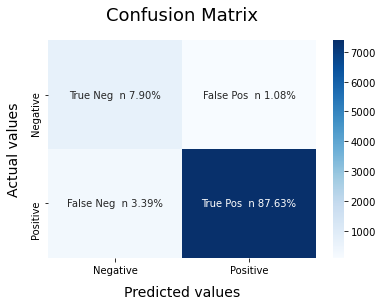

In [82]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)
print("Test Accuracy: %0.4f" % SVCmodel.score(X_test, y_test))

              precision    recall  f1-score   support

    Negative       0.89      0.39      0.54       952
    Positive       0.93      0.99      0.96      7478

    accuracy                           0.93      8430
   macro avg       0.91      0.69      0.75      8430
weighted avg       0.92      0.93      0.91      8430

Test Accuracy: 0.9254


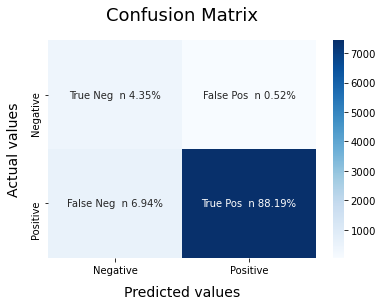

In [86]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)
print("Test Accuracy: %0.4f" % LRmodel.score(X_test, y_test))